# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


In [31]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot, lineplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

def plot_series_hist_acf_kpss(Yt: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=Yt, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(Yt, lags=lags)
    plt.show()

    ax = histplot(Yt, bins=hist_bins, kde=True)
    plt.show()

    # Compare median and mean
    print(Yt.describe())

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(Yt, regression='c', store=True)    # hypothesis: constant
    "KPSS={}".format(kpss_stat)# around a mean

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=Yt, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    fitted_ = model_fit.fittedvalues[y.index]
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame({'actual': y, 'fitted': fitted_}), ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series):
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': y_pred.abs().max(),
        'MIN_ABS': y_pred.abs().min()}


def model_errors(y: Series, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

# Preprocessing
Feature engineering, create categorial columns

In [32]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})

# FEATURE ENGINEERING
## StateHoliday -> categorial
df_train['StateHoliday'] = df_train['StateHoliday'].astype('category')

## StateHoliday -> categorial
df_train['DayOfWeek'] = df_train['DayOfWeek'].astype('category')

df_train.info()
df_train.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  category      
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  bool          
 6   Promo          1017209 non-null  bool          
 7   StateHoliday   1017209 non-null  category      
 8   SchoolHoliday  1017209 non-null  bool          
dtypes: bool(3), category(2), datetime64[ns](1), int64(3)
memory usage: 35.9 MB


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,True,True,0,True
1,2,5,2015-07-31,6064,625,True,True,0,True
2,3,5,2015-07-31,8314,821,True,True,0,True
3,4,5,2015-07-31,13995,1498,True,True,0,True
4,5,5,2015-07-31,4822,559,True,True,0,True


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,True,True,0,True
2015-07-30,1,4,5020,546,True,True,0,True
2015-07-29,1,3,4782,523,True,True,0,True
2015-07-28,1,2,5011,560,True,True,0,True
2015-07-27,1,1,6102,612,True,True,0,True
2015-07-25,1,6,4364,500,True,False,0,False
2015-07-24,1,5,3706,459,True,False,0,False
2015-07-23,1,4,3769,503,True,False,0,False
2015-07-22,1,3,3464,463,True,False,0,False


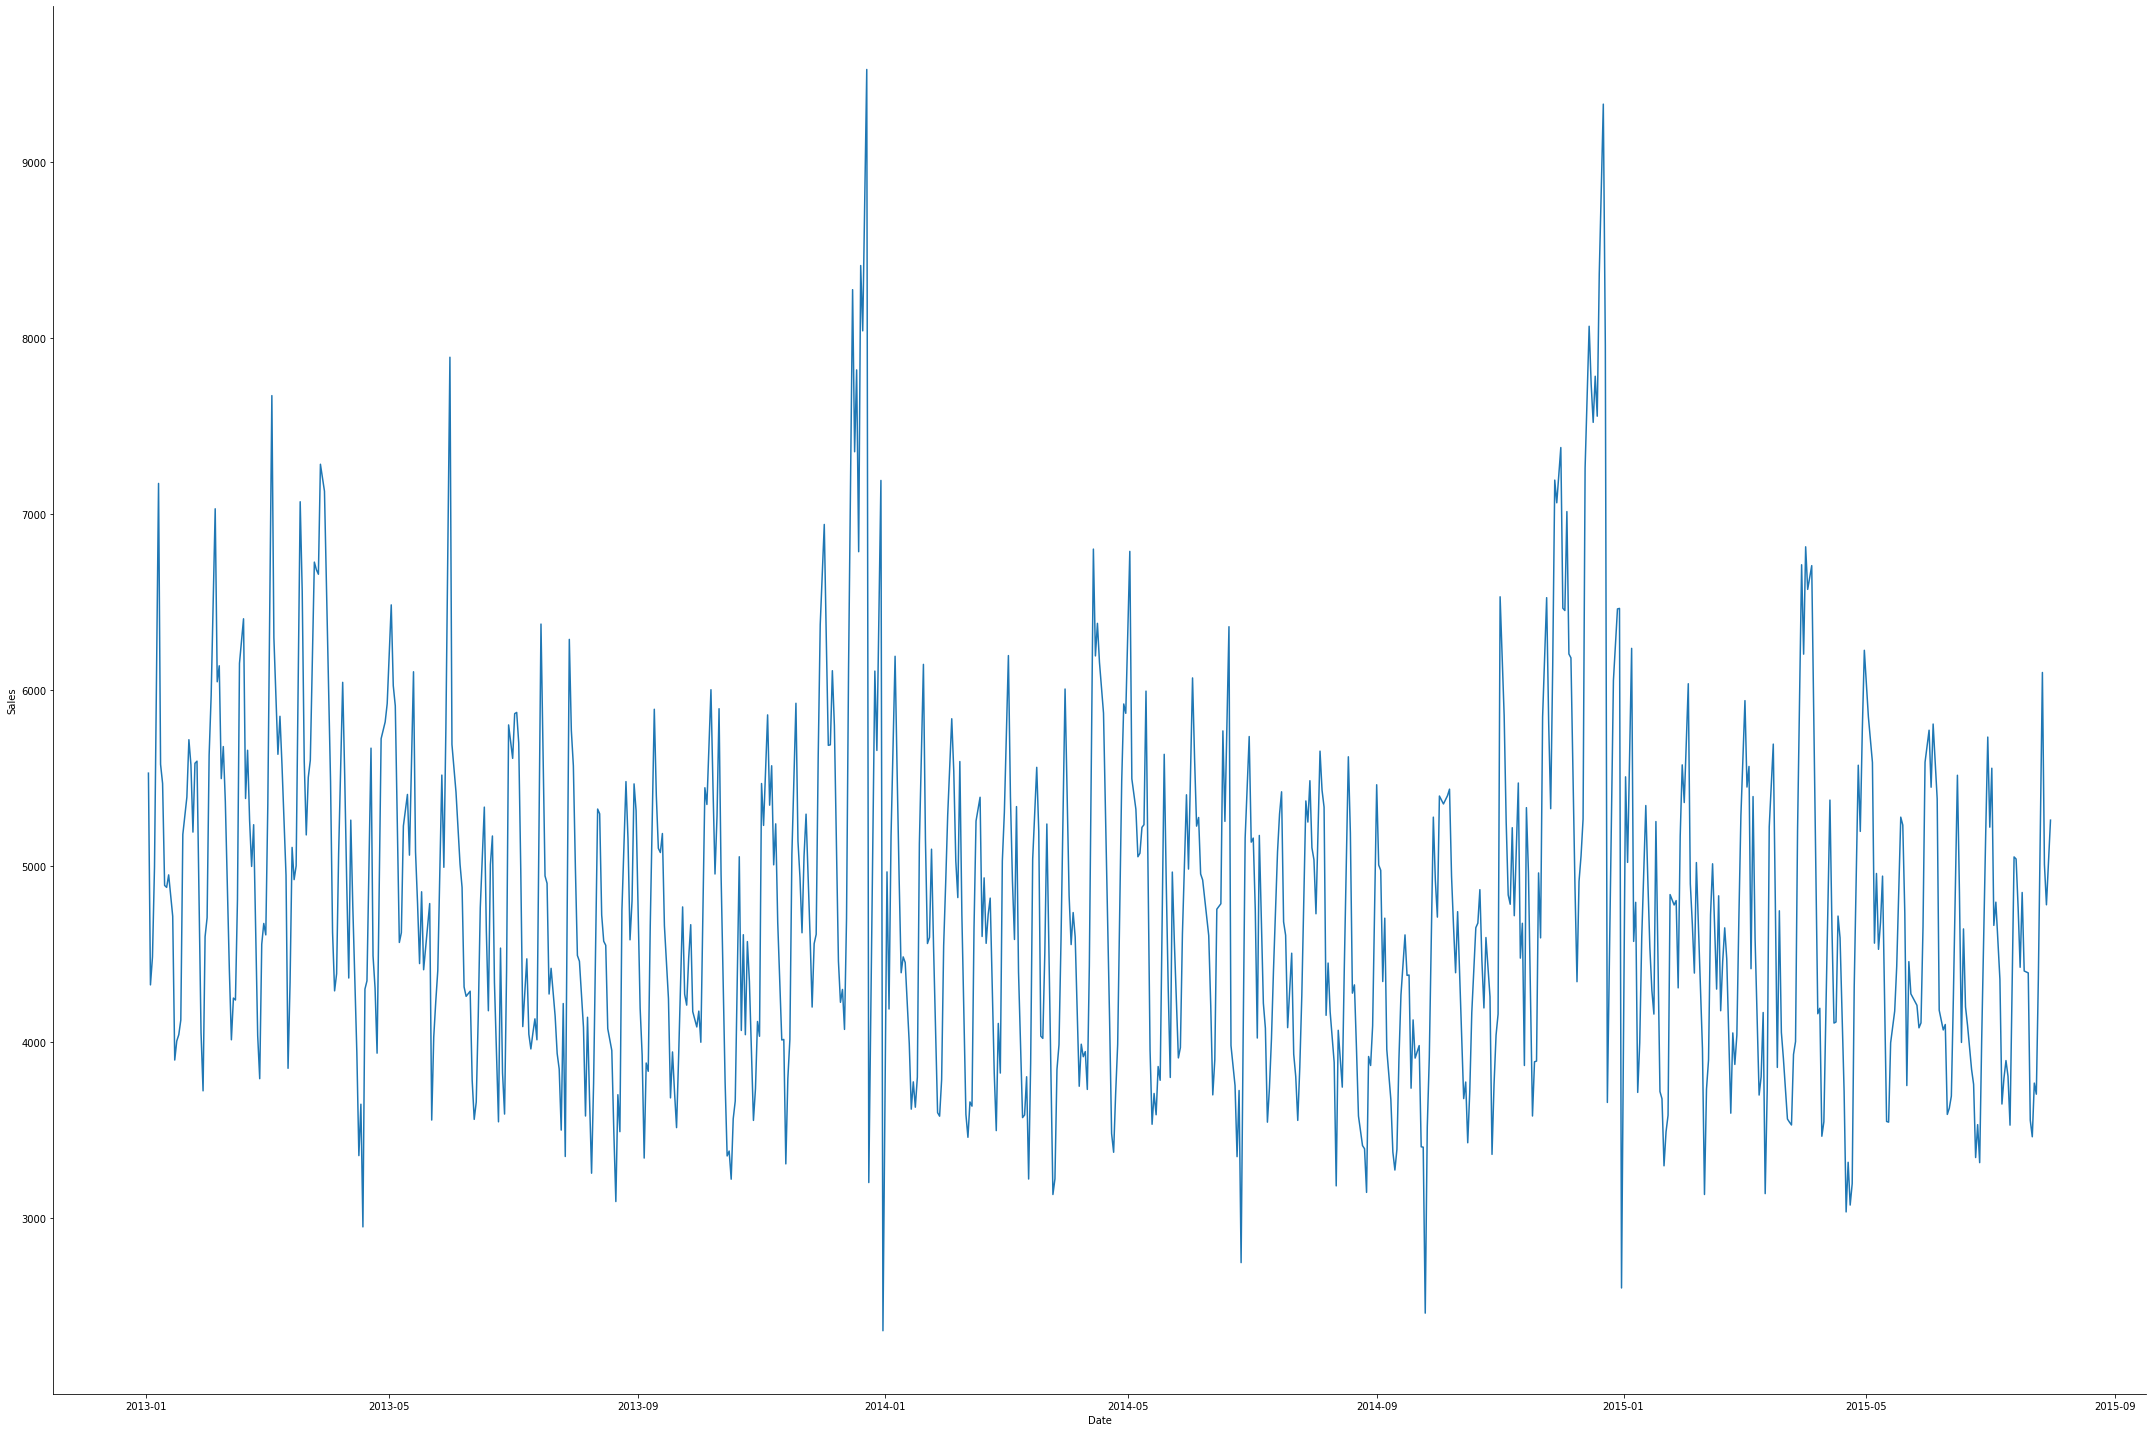

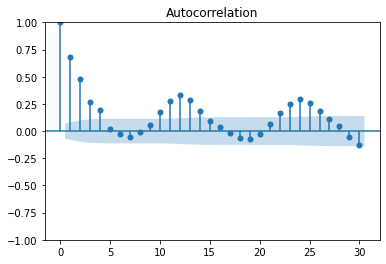

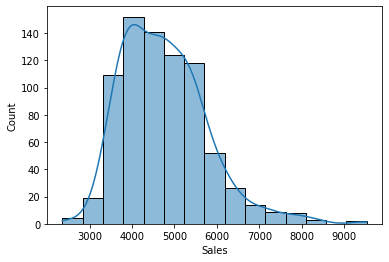

count     781.000000
mean     4759.096031
std      1012.106393
min      2362.000000
25%      4000.000000
50%      4647.000000
75%      5348.000000
max      9528.000000
Name: Sales, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [33]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

# Grouped by Store
df_train_stores = df_train.groupby(by=['Store'])
#df_train_stores.Date.max()
#df_train_stores.Date.min()
df_train_store_1 = df_train_stores.get_group(1).set_index('Date')
sales_zero_idx = df_train_store_1[df_train_store_1['Sales'] == 0].index
df_train_store_1 = df_train_store_1.drop(sales_zero_idx)
#df_train_store_1['2015-01-01':'2015-02-01'].tail(10)
df_train_store_1.head(10)

y_t = df_train_store_1['Sales']

plot_series_hist_acf_kpss(y_t, lags=30)

# Forecast |


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it

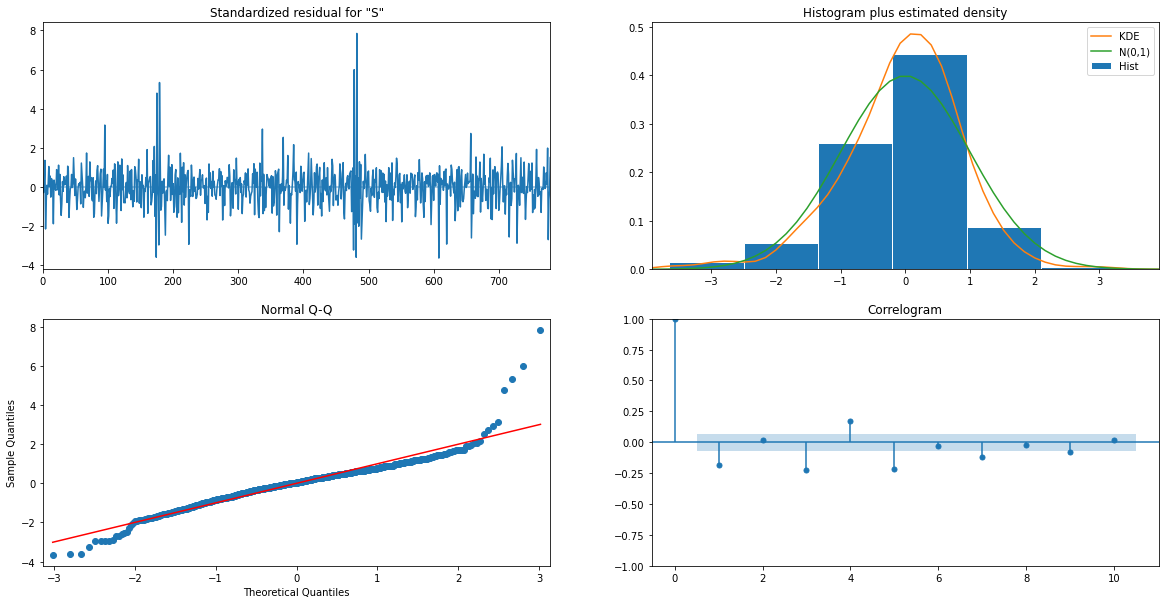

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6326.655
Date:                Thu, 25 Nov 2021   AIC                          12657.310
Time:                        15:09:01   BIC                          12666.628
Sample:                             0   HQIC                         12660.894
                                - 781                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3423     29.709      0.012      0.991     -57.887      58.572
sigma2      6.497e+05    1.5e+04     43.387      0.000     6.2e+05    6.79e+05
===================================================================================
Ljung-Box (L1) (Q):                  25.70   Jarque-Bera (JB):              2275.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.76
Prob(H) (two-sided):                  0.09   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

model: SARIMAX = SARIMAX(y_t, order=(0, 1, 0), trend='c')
model_fit: SARIMAXResults = model.fit()

f = model_fit.plot_diagnostics(lags=10, figsize=(20, 10))
plt.show()

model_fit.summary()

# Interpretation
If the residuals of the differenced model is white noise (stationary, no positive auto correletions and normal distributed diffs with constant variance and mean (which is near zero) it is best to use random walk with trend cause it will no get better than using last observation added with average trend of the whole past.

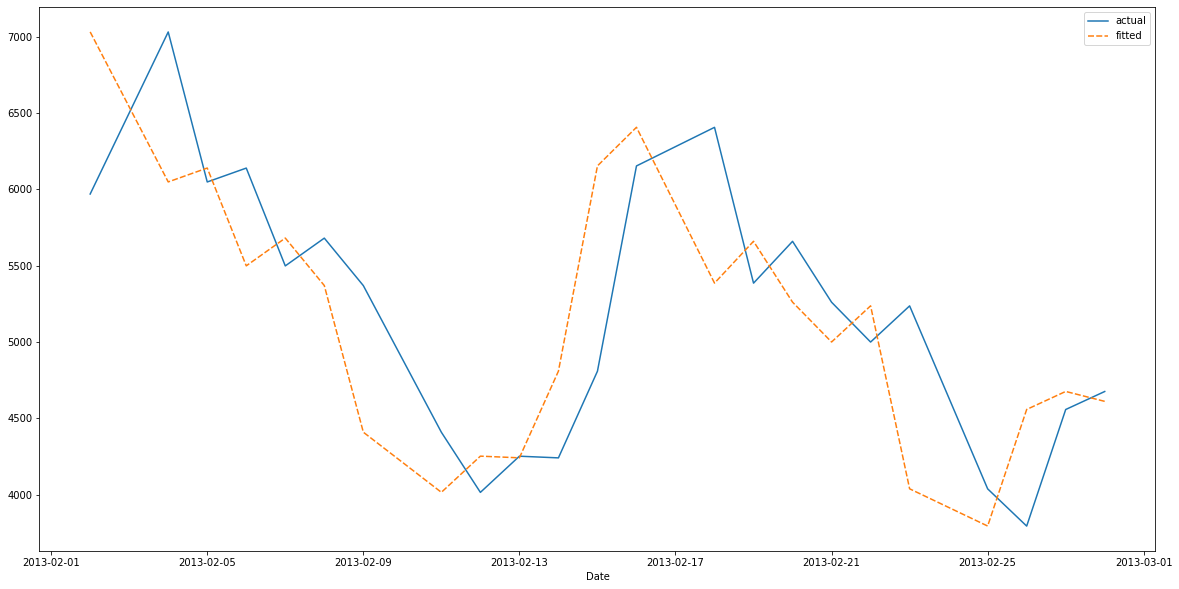

{'RMSE': 802.3991584506108,
 'MAPE': 0.1215066159480328,
 'MAE': 567.173346303502,
 'MEDIAN_AE': 427.6576923076923,
 'MAX_ABS': 9528.342307692308,
 'MIN_ABS': 2362.3423076923086}

In [37]:
plot_actual_and_fitted_values(y_t['2013-02-01':'2013-02-28'], model_fit)

model_errors(y_t.iloc[5:-5], model_fit)